# Simple Image Classifier

image classifier PyTorch on CIFAR-10

<img alt="A photo of a man on an elephant with an ML-generated overlay showing objects in the frame" src="https://upload.wikimedia.org/wikipedia/commons/a/ae/DenseCap_%28Johnson_et_al.%2C_2016%29_%28cropped%29.png" width=450px>

An image classifier is an ML model that recognizes objects in images. We can build image classifiers by feeding tens of thousands of labelled images to a neural network. Tools like PyTorch train these networks by evaluating their performance against the dataset.

Let's build an image classifier that detects planes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. We'll download a dataset, configure a neural network, train a model, and evaluate its performance.

## Step 1: Download a dataset and preview images

A model is only as good as its dataset.

Training tools need lots of high-quality data to build accurate models. We'll use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 60,000 photos to build our image classifier. Get started by downloading the dataset with `torchvision` and previewing a handful of images from it.

Files already downloaded and verified
Files already downloaded and verified


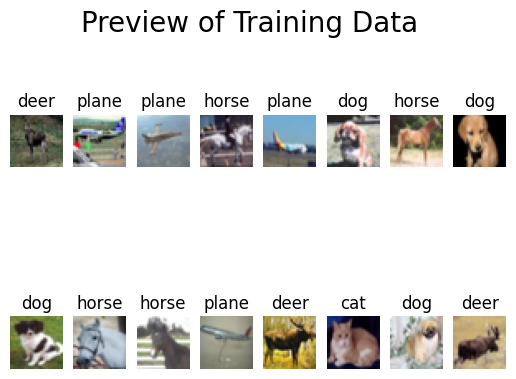

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Download the CIFAR-10 dataset to ./data
batch_size=16
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
print("Downloading data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Our model will recognize these kinds of objects
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Grab images from our training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    plt.title(classes[labels[i]])

plt.suptitle('Preview of Training Data', size=20)
plt.show()

# Step 2: Configure the neural network

Now that we have our dataset, we need to set up a neural network for PyTorch. Our neural network will transform an image into a description.

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau

# Define a convolutional neural network
class Net(nn.Module):
    SLOPE = 0.01
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        #init Conv2d
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')

        # Initialize linear weights
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('leaky_relu', Net.SLOPE))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('leaky_relu', Net.SLOPE))
        nn.init.xavier_uniform_(self.fc3.weight, gain=1.0)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x), negative_slope=Net.SLOPE)
        x = F.leaky_relu(self.fc2(x), negative_slope=Net.SLOPE)
        x = F.softmax(self.fc3(x), dim=1)
        # x = self.fc3(x)
        return x
net = Net()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=5e-5, momentum=0.9, weight_decay=1e-5)
# Define the learning rate scheduler
## scheduler = ExponentialLR(optimizer, gamma=0.8)  # gamma controls the decay rate
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=1, threshold=1e-4, verbose=True)

# Load previously trained model
PATH = './cifar_net2.pth'
net.load_state_dict(torch.load(PATH))

print("Your network is ready for training!")

Your network is ready for training!


# Step 3: Train the network and save model

PyTorch trains our network by adjusting its parameters and evaluating its performance against our labelled dataset.

In [21]:
from tqdm import tqdm

EPOCHS = 30
net.train()
print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, 
                                  desc=f"Epoch {epoch + 1} of {EPOCHS} / lr={scheduler.get_last_lr()[0]:.1e}",
                                  leave=True, ncols=80)):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")
    scheduler.step(running_loss / len(trainloader))

# Save our trained model
torch.save(net.state_dict(), PATH)
print(" ... finished")

Training...


Epoch 1 of 30 / lr=5.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 215.25it/s]


Epoch 1, Loss: 2.0072997909164427


Epoch 2 of 30 / lr=5.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 211.89it/s]


Epoch 2, Loss: 2.006666312828064


Epoch 3 of 30 / lr=5.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 213.96it/s]


Epoch 3, Loss: 2.0060076781845093


Epoch 4 of 30 / lr=5.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 214.23it/s]


Epoch 4, Loss: 2.0051077294158937


Epoch 5 of 30 / lr=5.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 214.85it/s]


Epoch 5, Loss: 2.0047630891418455


Epoch 6 of 30 / lr=5.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 215.01it/s]


Epoch 6, Loss: 2.00422462310791


Epoch 7 of 30 / lr=5.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 214.84it/s]


Epoch 7, Loss: 2.0036373920059205


Epoch 8 of 30 / lr=5.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 216.68it/s]


Epoch 8, Loss: 2.003048087654114


Epoch 9 of 30 / lr=5.0e-05: 100%|██████████| 3125/3125 [00:14<00:00, 215.08it/s]


Epoch 9, Loss: 2.00254330783844


Epoch 10 of 30 / lr=5.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 215.70it/s]


Epoch 10, Loss: 2.002032073020935


Epoch 11 of 30 / lr=5.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 216.25it/s]


Epoch 11, Loss: 2.0020473152923586


Epoch 12 of 30 / lr=5.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 215.67it/s]


Epoch 12, Loss: 2.0016806928634643


Epoch 13 of 30 / lr=5.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 215.77it/s]


Epoch 13, Loss: 2.000918161239624


Epoch 14 of 30 / lr=5.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 216.13it/s]


Epoch 14, Loss: 2.000619967422485


Epoch 15 of 30 / lr=5.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 213.22it/s]


Epoch 15, Loss: 2.0007993756103515


Epoch 16 of 30 / lr=5.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 214.43it/s]


Epoch 16, Loss: 2.000278910865784


Epoch 17 of 30 / lr=5.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 215.37it/s]


Epoch 17, Loss: 1.9999923633956909


Epoch 18 of 30 / lr=5.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 215.07it/s]


Epoch 18, Loss: 1.9997839112472535


Epoch 19 of 30 / lr=5.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 215.39it/s]


Epoch 19, Loss: 1.999530054283142


Epoch 20 of 30 / lr=5.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 214.87it/s]


Epoch 20, Loss: 1.9993780968856811


Epoch 21 of 30 / lr=5.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 214.79it/s]


Epoch 21, Loss: 1.9992061658096314


Epoch 22 of 30 / lr=5.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 215.52it/s]


Epoch 22, Loss: 1.9991977576065063


Epoch 23 of 30 / lr=5.0e-05: 100%|█████████| 3125/3125 [00:14<00:00, 212.26it/s]


Epoch 23, Loss: 1.9991487225723266


Epoch 24 of 30 / lr=1.5e-05: 100%|█████████| 3125/3125 [00:14<00:00, 212.66it/s]


Epoch 24, Loss: 1.9987201109313966


Epoch 25 of 30 / lr=1.5e-05: 100%|█████████| 3125/3125 [00:14<00:00, 213.09it/s]


Epoch 25, Loss: 1.9986290211486817


Epoch 26 of 30 / lr=1.5e-05: 100%|█████████| 3125/3125 [00:14<00:00, 214.87it/s]


Epoch 26, Loss: 1.9986130363082886


Epoch 27 of 30 / lr=4.5e-06: 100%|█████████| 3125/3125 [00:14<00:00, 213.36it/s]


Epoch 27, Loss: 1.9985286598587035


Epoch 28 of 30 / lr=4.5e-06: 100%|█████████| 3125/3125 [00:14<00:00, 213.83it/s]


Epoch 28, Loss: 1.9985051328277588


Epoch 29 of 30 / lr=4.5e-06: 100%|█████████| 3125/3125 [00:14<00:00, 217.21it/s]


Epoch 29, Loss: 1.9984918523025512


Epoch 30 of 30 / lr=4.5e-06: 100%|█████████| 3125/3125 [00:14<00:00, 214.98it/s]

Epoch 30, Loss: 1.9984837596511842
 ... finished


# Step 4: Test the trained model

Let's test our model!

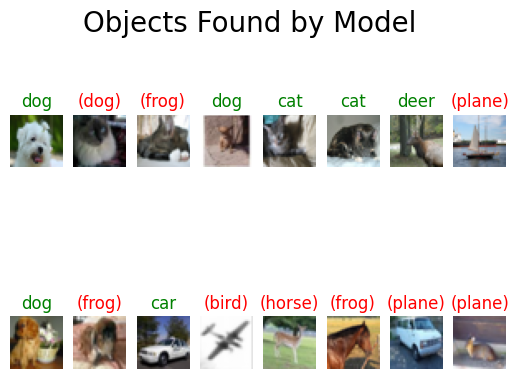

In [22]:
# Pick random photos from training set
if dataiter == None:
    dataiter = iter(testloader)
images, labels = next(dataiter)

# Load our model
net = Net()
net.load_state_dict(torch.load(PATH))
net.eval()

# Analyze images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.show()

# Step 5: Evaluate model accuracy

Let's conclude by evaluating our model's overall performance.

In [23]:
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.1 %
Accuracy for class: car   is 64.4 %
Accuracy for class: bird  is 27.4 %
Accuracy for class: cat   is 28.7 %
Accuracy for class: deer  is 30.4 %
Accuracy for class: dog   is 47.7 %
Accuracy for class: frog  is 64.1 %
Accuracy for class: horse is 54.1 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 55.7 %


## Step 6 - Inspect model


In [24]:
weights = net.fc3.weight
print(weights)


Parameter containing:
tensor([[-1.3672e-01,  4.0029e-01,  5.7645e-01, -3.3888e-02,  6.6656e-02,
         -4.0604e-01, -2.4491e-01,  1.9073e-01, -8.4782e-02, -5.0553e-01,
          7.5375e-02,  4.2102e-01,  2.2016e-01, -8.4771e-03,  2.7705e-01,
         -4.2436e-01,  1.2638e-01, -2.8549e-01,  9.1568e-01, -2.2288e-01,
         -3.7251e-01,  3.1512e-02,  2.4632e-04,  3.8578e-02, -3.0969e-01,
         -7.6416e-02,  1.6518e-01, -1.7282e-01,  1.4095e-01,  1.0071e-01,
          1.5173e-01, -1.6969e-01,  1.1072e-01,  7.7862e-02,  1.4675e-02,
          2.2070e-03,  1.4536e-01, -5.3139e-02, -4.9399e-02, -1.0414e-01,
         -8.9186e-02,  1.1394e-01, -6.6783e-03, -1.7586e-01, -1.6574e-01,
          2.0155e-01,  1.0389e-01,  1.8236e-01, -4.7123e-02, -2.2876e-01,
         -4.6462e-02,  1.7953e-01,  2.0422e-01, -4.1098e-01,  9.6355e-01,
         -2.3085e-01, -3.8087e-01,  8.6457e-02, -1.0569e-01,  3.1439e-02,
         -7.2313e-02,  4.6566e-01, -7.0508e-02, -9.4618e-02, -3.7825e-02,
          4.7507